### Machine Learning Model Development

1. Datasource: 
    - https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset

2. Objective:
    - To correctly classify a person if he is going to be leaving the company or not.
    
3. Encoding:
    - No Attrition = 0 | Attrition = 1
    
4. Metrics:
    -  Overall Accuracy & Recall.
    
5. Scope:
    - Limited to the models being tried out here with a small set of hypertuned parameters. [Owing to hardware limitations]

6. Excerpts from Exploratory Data Analyses (EDA)
    - monthly income
    - MinMax Scaler to be Used.
    - Strong case for upsampling / downsampling.
    

In [1]:
# Import Relevant Libraries

# -------------- Basic Libraries ----------------------
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', 10000)
pd.options.display.width=None
from tabulate import tabulate
tabulate.PRESERVE_WHITESPACE = False

from scipy import stats

# --------------- sklearn libraries ---------------------

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import catboost as cb

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Sequential

In [2]:
# Global constants

RND_STATE = 39  # random_state where used is assigned RND_STATE
TESTSIZE = 0.2  # test_size where used is assigned TESTSIZE

In [3]:
PATH = r"C:\DSML_Case_Studies\01_Classification\01_Dataset"
OUTPATH = r"C:\DSML_Case_Studies\01_Classification\03_Output"
DATASET = r"\Dataset_IBM_Attrition_34x1.csv"
PREFIX = r"\IBM_Attrition_"

# Specify number of features and targets

n_features = 18
n_target = 1

In [4]:
# Dataframe Definition & Classifying Features & Targets

df = pd.read_csv(f"{PATH}{DATASET}")
df = df.round(decimals=3)
# df=df.drop(columns=['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours', 'MonthlyIncome'])

colsel = ['JobLevel', 'OverTime', 'TotalWorkingYears', 'JobRole', 'YearsWithCurrManager', 'Age', 'DistanceFromHome',
          'WorkLifeBalance', 'MaritalStatus', 'YearsSinceLastPromotion', 'Gender', 'TrainingTimesLastYear',
          'RelationshipSatisfaction', 'EnvironmentSatisfaction', 'MonthlyIncome', 'PercentSalaryHike',
          'StockOptionLevel', 'YearsAtCompany', 'Attrition']
df = df.filter(colsel, axis=1)

collst = []
for columns in df.columns:
    collst.append(columns)

featlst = collst[0:len(collst)-n_target]
targlst = collst[-n_target:]

cat_df = df.select_dtypes(include=['object'])
catlst = []
for col in cat_df.columns:
    catlst.append(col)

y_catlst = [value for value in catlst if value in targlst]

In [5]:
print("Dataframe BEFORE Encoding: ")

Dataframe BEFORE Encoding: 


In [6]:
df.head()

,JobLevel,OverTime,TotalWorkingYears,JobRole,YearsWithCurrManager,Age,DistanceFromHome,WorkLifeBalance,MaritalStatus,YearsSinceLastPromotion,Gender,TrainingTimesLastYear,RelationshipSatisfaction,EnvironmentSatisfaction,MonthlyIncome,PercentSalaryHike,StockOptionLevel,YearsAtCompany,Attrition
0,2,Yes,8,Sales Executive,5,41,1,1,Single,0,Female,0,1,2,5993,11,0,6,Yes
1,2,No,10,Research Scientist,7,49,8,3,Married,1,Male,3,4,3,5130,23,1,10,No
2,1,Yes,7,Laboratory Technician,0,37,2,3,Single,0,Male,3,2,4,2090,15,0,0,Yes
3,1,Yes,8,Research Scientist,0,33,3,3,Married,3,Female,3,3,4,2909,11,0,8,No
4,1,No,6,Laboratory Technician,2,27,2,3,Married,2,Male,3,4,1,3468,12,1,2,No


In [7]:
# Encode Categorical Columns

for i in range(0, len(collst), 1):
    temp = df.dtypes[collst[i]]
    if temp == 'object':
        df[collst[i]] = df[collst[i]].astype('category')
        df[collst[i]] = df[collst[i]].cat.codes
    else:
        continue
        
# Features & Target DataFrame

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

In [8]:
print("Dataframe AFTER Encoding: ")

Dataframe AFTER Encoding: 


In [9]:
df.head()

,JobLevel,OverTime,TotalWorkingYears,JobRole,YearsWithCurrManager,Age,DistanceFromHome,WorkLifeBalance,MaritalStatus,YearsSinceLastPromotion,Gender,TrainingTimesLastYear,RelationshipSatisfaction,EnvironmentSatisfaction,MonthlyIncome,PercentSalaryHike,StockOptionLevel,YearsAtCompany,Attrition
0,2,1,8,7,5,41,1,1,2,0,0,0,1,2,5993,11,0,6,1
1,2,0,10,6,7,49,8,3,1,1,1,3,4,3,5130,23,1,10,0
2,1,1,7,2,0,37,2,3,2,0,1,3,2,4,2090,15,0,0,1
3,1,1,8,6,0,33,3,3,1,3,0,3,3,4,2909,11,0,8,0
4,1,0,6,2,2,27,2,3,1,2,1,3,4,1,3468,12,1,2,0


In [10]:
print("Dataframe BEFORE Imputing: ")

Dataframe BEFORE Imputing: 


In [11]:
print(df.isnull().sum(), end='\n\n')

JobLevel                    0
OverTime                    0
TotalWorkingYears           0
JobRole                     0
YearsWithCurrManager        0
Age                         0
DistanceFromHome            0
WorkLifeBalance             0
MaritalStatus               0
YearsSinceLastPromotion     0
Gender                      0
TrainingTimesLastYear       0
RelationshipSatisfaction    0
EnvironmentSatisfaction     0
MonthlyIncome               0
PercentSalaryHike           0
StockOptionLevel            0
YearsAtCompany              0
Attrition                   0
dtype: int64



In [12]:
# Basic Imputing

''' Use Appropriate Imputer - Mean, Meadian, Mode... Others '''

df = df.apply(lambda x: x.fillna(x.median()), axis=0)

In [13]:
print("Dataframe AFTER MEDIAN Imputing: ")

Dataframe AFTER MEDIAN Imputing: 


In [14]:
print(df.isnull().sum(), end='\n\n')

JobLevel                    0
OverTime                    0
TotalWorkingYears           0
JobRole                     0
YearsWithCurrManager        0
Age                         0
DistanceFromHome            0
WorkLifeBalance             0
MaritalStatus               0
YearsSinceLastPromotion     0
Gender                      0
TrainingTimesLastYear       0
RelationshipSatisfaction    0
EnvironmentSatisfaction     0
MonthlyIncome               0
PercentSalaryHike           0
StockOptionLevel            0
YearsAtCompany              0
Attrition                   0
dtype: int64



In [15]:
"""
    1. Cell for removing outliers.
    2. Based on Z-score.
"""
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] # Removing the Outliers using Z-Scored Method

In [16]:
# Sanity checks before proceeding further

print("List of Features:", featlst, end='\n\n')
print("List of Targets:", targlst, end='\n\n')
print("List of Categorical Variables:", catlst, end='\n\n')
print("List of Categorical Targets", y_catlst, end='\n\n')

List of Features: ['JobLevel', 'OverTime', 'TotalWorkingYears', 'JobRole', 'YearsWithCurrManager', 'Age', 'DistanceFromHome', 'WorkLifeBalance', 'MaritalStatus', 'YearsSinceLastPromotion', 'Gender', 'TrainingTimesLastYear', 'RelationshipSatisfaction', 'EnvironmentSatisfaction', 'MonthlyIncome', 'PercentSalaryHike', 'StockOptionLevel', 'YearsAtCompany']

List of Targets: ['Attrition']

List of Categorical Variables: ['OverTime', 'JobRole', 'MaritalStatus', 'Gender', 'Attrition']

List of Categorical Targets ['Attrition']



In [17]:
print("Descriptive Stats: ")

Descriptive Stats: 


In [18]:
desc_stat = df.describe().T.round(3) # Univariate analyses
print(tabulate(desc_stat, headers=desc_stat.columns, tablefmt="github", numalign="right"))

|                          |   count |    mean |     std |   min |     25% |   50% |     75% |   max |
|--------------------------|---------|---------|---------|-------|---------|-------|---------|-------|
| JobLevel                 |    1396 |   1.968 |   1.026 |     1 |       1 |     2 |       2 |     5 |
| OverTime                 |    1396 |   0.283 |   0.451 |     0 |       0 |     0 |       1 |     1 |
| TotalWorkingYears        |    1396 |  10.384 |   6.759 |     0 |       6 |     9 |      14 |    34 |
| JobRole                  |    1396 |   4.506 |   2.476 |     0 |       2 |     5 |       7 |     8 |
| YearsWithCurrManager     |    1396 |    3.83 |   3.273 |     0 |       2 |     3 |       7 |    14 |
| Age                      |    1396 |  36.313 |   8.849 |    18 |      30 |    35 |      42 |    60 |
| DistanceFromHome         |    1396 |   9.176 |    8.09 |     1 |       2 |     7 |      14 |    29 |
| WorkLifeBalance          |    1396 |   2.765 |   0.705 |     1 |       

In [19]:
# Train-Test Split

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TESTSIZE, random_state=RND_STATE)


In [20]:
# Over Sampling

from imblearn.over_sampling import RandomOverSampler

print("Before Upsampling:", y_train.Attrition.value_counts())

ros = RandomOverSampler(random_state=RND_STATE)
X_train, y_train = ros.fit_resample(X_train, y_train)

print("After Upsampling:", y_train.Attrition.value_counts())

Before Upsampling: 0    934
1    182
Name: Attrition, dtype: int64
After Upsampling: 0    934
1    934
Name: Attrition, dtype: int64


In [21]:
# # Under Sampling

# from imblearn.under_sampling import RandomUnderSampler

# print("Before Downsampling:", y_train.Attrition.value_counts())

# rus = RandomUnderSampler(random_state=RND_STATE)
# X_train, y_train = rus.fit_resample(X_train, y_train)

# print("After Undersampling:", y_train.Attrition.value_counts())

In [22]:
print("Train Dataset - Features: ")

Train Dataset - Features: 


In [23]:
X_train.head()

,JobLevel,OverTime,TotalWorkingYears,JobRole,YearsWithCurrManager,Age,DistanceFromHome,WorkLifeBalance,MaritalStatus,YearsSinceLastPromotion,Gender,TrainingTimesLastYear,RelationshipSatisfaction,EnvironmentSatisfaction,MonthlyIncome,PercentSalaryHike,StockOptionLevel,YearsAtCompany
0,2,1,10,7,8,31,26,3,1,0,1,4,3,1,5617,11,0,10
1,3,0,9,7,7,49,11,4,1,7,0,3,1,3,7654,18,2,9
2,1,0,8,2,0,42,8,3,2,0,1,3,4,4,3968,13,0,0
3,1,0,3,1,1,24,10,3,1,2,1,2,4,1,2145,14,1,2
4,2,0,9,0,7,28,16,3,2,0,1,2,3,2,5661,19,0,8


In [24]:
print("Test Dataset - Features: ")

Test Dataset - Features: 


In [25]:
X_test.head()

,JobLevel,OverTime,TotalWorkingYears,JobRole,YearsWithCurrManager,Age,DistanceFromHome,WorkLifeBalance,MaritalStatus,YearsSinceLastPromotion,Gender,TrainingTimesLastYear,RelationshipSatisfaction,EnvironmentSatisfaction,MonthlyIncome,PercentSalaryHike,StockOptionLevel,YearsAtCompany
1444,1,0,14,2,8,56,7,1,1,9,1,4,4,4,2339,11,1,10
698,2,0,5,7,0,35,18,3,1,1,0,3,2,3,4601,16,0,5
1376,1,0,10,6,3,38,9,4,0,0,1,0,4,2,4771,19,2,5
183,1,0,5,2,2,50,1,2,1,0,1,2,4,3,3690,15,1,3
1232,2,0,17,4,7,35,27,3,1,0,1,3,2,4,6883,16,1,7


In [26]:
print("Train Dataset - Target: ")

Train Dataset - Target: 


In [27]:
y_train.head()

,Attrition
0,1
1,1
2,0
3,0
4,0


In [28]:
print("Test Dataset - Target: ")

Test Dataset - Target: 


In [29]:
y_test.head()

,Attrition
1444,1
698,0
1376,0
183,0
1232,0


In [30]:
# Scaling

# scaler = StandardScaler()
scaler = MinMaxScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_sc_df = pd.DataFrame(scaler.fit_transform(X_train), columns=featlst)
X_test_sc_df = pd.DataFrame(scaler.transform(X_test), columns=featlst)

In [31]:
print("Train Dataset Scaled - Features:")

Train Dataset Scaled - Features:


In [32]:
X_train_sc_df.head()

,JobLevel,OverTime,TotalWorkingYears,JobRole,YearsWithCurrManager,Age,DistanceFromHome,WorkLifeBalance,MaritalStatus,YearsSinceLastPromotion,Gender,TrainingTimesLastYear,RelationshipSatisfaction,EnvironmentSatisfaction,MonthlyIncome,PercentSalaryHike,StockOptionLevel,YearsAtCompany
0,0.25,1.0,0.294118,0.875,0.571429,0.309524,0.892857,0.666667,0.5,0.000000,1.0,0.666667,0.666667,0.000000,0.242987,0.000000,0.000000,0.40
1,0.50,0.0,0.264706,0.875,0.500000,0.738095,0.357143,1.000000,0.5,0.636364,0.0,0.500000,0.000000,0.666667,0.350401,0.500000,0.666667,0.36
2,0.00,0.0,0.235294,0.250,0.000000,0.571429,0.250000,0.666667,1.0,0.000000,1.0,0.500000,1.000000,1.000000,0.156032,0.142857,0.000000,0.00
3,0.00,0.0,0.088235,0.125,0.071429,0.142857,0.321429,0.666667,0.5,0.181818,1.0,0.333333,1.000000,0.000000,0.059903,0.214286,0.333333,0.08
4,0.25,0.0,0.264706,0.000,0.500000,0.238095,0.535714,0.666667,1.0,0.000000,1.0,0.333333,0.666667,0.333333,0.245307,0.571429,0.000000,0.32


In [33]:
print("Test Dataset Scaled - Features:")

Test Dataset Scaled - Features:


In [34]:
X_test_sc_df.head()

,JobLevel,OverTime,TotalWorkingYears,JobRole,YearsWithCurrManager,Age,DistanceFromHome,WorkLifeBalance,MaritalStatus,YearsSinceLastPromotion,Gender,TrainingTimesLastYear,RelationshipSatisfaction,EnvironmentSatisfaction,MonthlyIncome,PercentSalaryHike,StockOptionLevel,YearsAtCompany
0,0.00,0.0,0.411765,0.250,0.571429,0.904762,0.214286,0.000000,0.5,0.818182,1.0,0.666667,1.000000,1.000000,0.070133,0.000000,0.333333,0.40
1,0.25,0.0,0.147059,0.875,0.000000,0.404762,0.607143,0.666667,0.5,0.090909,0.0,0.500000,0.333333,0.666667,0.189412,0.357143,0.000000,0.20
2,0.00,0.0,0.294118,0.750,0.214286,0.476190,0.285714,1.000000,0.0,0.000000,1.0,0.000000,1.000000,0.333333,0.198376,0.571429,0.666667,0.20
3,0.00,0.0,0.147059,0.250,0.142857,0.761905,0.000000,0.333333,0.5,0.000000,1.0,0.333333,1.000000,0.666667,0.141373,0.285714,0.333333,0.12
4,0.25,0.0,0.500000,0.500,0.500000,0.404762,0.928571,0.666667,0.5,0.000000,1.0,0.500000,0.333333,1.000000,0.309745,0.357143,0.333333,0.28


In [ ]:
# Hyperparameter Tuning for Logistic Regression Model

Log_Reg = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2']
c_values = [10000, 1000, 100, 10, 1.0, 0.1, 0.01]


grid = dict(solver=solvers, penalty=penalty, C=c_values)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=Log_Reg, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

LR_Best = grid_search.best_params_

In [36]:
# Model: Logistic Regression (LR)

Log_Reg = LogisticRegression(**LR_Best).fit(X_train_sc, y_train)

# Prediction

y_pred = Log_Reg.predict(X_test_sc)

Train_Acc_LR = round(Log_Reg.score(X_train_sc, y_train),2)
Test_Acc_LR = round(Log_Reg.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_LR = CM[0, 0]
TN_LR = CM[1, 1]
FP_LR = CM[1, 0]
FN_LR = CM[0, 1]

Precision_LR = round(TP_LR/(TP_LR + FP_LR), 2)
Recall_LR = round(TP_LR/(TP_LR+FN_LR), 2)
f1_LR = round((2*Precision_LR*Recall_LR)/(Precision_LR+Recall_LR), 2)
Specificity_LR = round(TN_LR/(TN_LR+FP_LR), 2)
AUC_LR = round(roc_auc_score(y_test, y_pred), 2)

fpr_LR, tpr_LR, threshold_LR = roc_curve(y_test, y_pred, pos_label=1)

In [37]:
LR_Rep = classification_report(y_test, y_pred, output_dict=True)
LR_Rep_df = pd.DataFrame(LR_Rep).transpose()

In [38]:
print("-------- Logistic Regression Summary -------- ")

-------- Logistic Regression Summary -------- 


In [39]:
LR_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.92,0.7,0.79,233.0
1,0.32,0.7,0.44,47.0
accuracy,0.70,0.7,0.70,0.7
macro avg,0.62,0.7,0.61,280.0
weighted avg,0.82,0.7,0.73,280.0


In [ ]:
# Hyperparameter Tunining for Tree Based Models

RFC = RandomForestClassifier()

n_estimators = [200, 600] # Number of Trees in the Forest
max_features = ['auto']
max_depth = [3, 5] # max number of levels in each decision tree
min_samples_split = [2, 5]
criterion = ['entropy', 'gini']

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'criterion': criterion
       }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=RFC, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
RFC_Best = grid_search.best_params_

In [41]:
# Model: Random Forest (RFC) 

RFC = RandomForestClassifier(**RFC_Best, random_state=RND_STATE)
RFC.fit(X_train_sc, y_train)

# Prediction

y_pred = RFC.predict(X_test_sc)

Train_Acc_RFC = round(RFC.score(X_train_sc, y_train),2)
Test_Acc_RFC = round(RFC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_RFC = CM[0, 0]
TN_RFC = CM[1, 1]
FP_RFC = CM[1, 0]
FN_RFC = CM[0, 1]

Precision_RFC = round(TP_RFC/(TP_RFC + FP_RFC), 2)
Recall_RFC = round(TP_RFC/(TP_RFC+FN_RFC), 2)
f1_RFC = round((2*Precision_RFC*Recall_RFC)/(Precision_RFC+Recall_RFC), 2)
Specificity_RFC = round(TN_RFC/(TN_RFC+FP_RFC), 2)
AUC_RFC = round(roc_auc_score(y_test, y_pred), 2)

fpr_RFC, tpr_RFC, threshold_RFC = roc_curve(y_test, y_pred, pos_label=1)

In [42]:
RFC_Rep = classification_report(y_test, y_pred, output_dict=True)
RFC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [43]:
print("-------- Random Forest Summary -------- ")

-------- Random Forest Summary -------- 


In [44]:
RFC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.90,0.82,0.86,233.00
1,0.38,0.53,0.44,47.00
accuracy,0.78,0.78,0.78,0.78
macro avg,0.64,0.68,0.65,280.00
weighted avg,0.81,0.78,0.79,280.00


In [ ]:
# Model: Hyper Parameter Tuning for Kernel Support Vector Machines

KSV = svm.SVC()

kernel = ['linear', 'rbf']
c_values = [1000, 100]
gamma = [0.001, 0.01]

grid = dict(kernel=kernel, C=c_values, gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=KSV, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)


# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
KSV_Best = grid_search.best_params_

In [46]:
# Model: Kernel Support Vector (KSV)

KSV = svm.SVC(**KSV_Best, random_state=RND_STATE)
KSV.fit(X_train_sc, y_train)

# Prediction

y_pred = KSV.predict(X_test_sc)

Train_Acc_KSV = round(KSV.score(X_train_sc, y_train),2)
Test_Acc_KSV = round(KSV.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_KSV = CM[0, 0]
TN_KSV = CM[1, 1]
FP_KSV = CM[1, 0]
FN_KSV = CM[0, 1]

Precision_KSV = round(TP_KSV/(TP_KSV + FP_KSV), 2)
Recall_KSV = round(TP_KSV/(TP_KSV+FN_KSV), 2)
f1_KSV = round((2*Precision_KSV*Recall_KSV)/(Precision_KSV+Recall_KSV), 2)
Specificity_KSV = round(TN_KSV/(TN_KSV+FP_KSV), 2)
AUC_KSV = round(roc_auc_score(y_test, y_pred), 2)

fpr_KSV, tpr_KSV, threshold_KSV = roc_curve(y_test, y_pred, pos_label=1)

In [47]:
KSV_Rep = classification_report(y_test, y_pred, output_dict=True)
KSV_Rep_df = pd.DataFrame(KSV_Rep).transpose()

In [48]:
print("-------- Kernel Support Vector Summary -------- ")

-------- Kernel Support Vector Summary -------- 


In [49]:
KSV_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.92,0.70,0.80,233.0
1,0.32,0.68,0.43,47.0
accuracy,0.70,0.70,0.70,0.7
macro avg,0.62,0.69,0.61,280.0
weighted avg,0.82,0.70,0.74,280.0


In [ ]:
# Model: CatBoost Classification (CBC)

train_dataset = cb.Pool(X_train_sc, y_train)
test_dataset = cb.Pool(X_test_sc, y_test)

CBC= cb.CatBoostClassifier(loss_function='Logloss', eval_metric='AUC')

grid = {'learning_rate': [0.03, 0.1],
'depth': [4, 6, 10],
'l2_leaf_reg': [1, 3, 5,],
'iterations': [50, 100, 150]}

CBC.grid_search(grid, train_dataset)
CBC.get_params()

# Prediction

y_pred = CBC.predict(X_test_sc)

Train_Acc_CBC = round(CBC.score(X_train_sc, y_train),2)
Test_Acc_CBC = round(CBC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_CBC = CM[0, 0]
TN_CBC = CM[1, 1]
FP_CBC = CM[1, 0]
FN_CBC = CM[0, 1]

Precision_CBC = round(TP_CBC/(TP_CBC + FP_CBC), 2)
Recall_CBC = round(TP_CBC/(TP_CBC+FN_CBC), 2)
f1_CBC = round((2*Precision_CBC*Recall_CBC)/(Precision_CBC+Recall_CBC), 2)
Specificity_CBC = round(TN_CBC/(TN_CBC+FP_CBC), 2)
AUC_CBC = round(roc_auc_score(y_test, y_pred), 2)

fpr_CBC, tpr_CBC, threshold_CBC = roc_curve(y_test, y_pred, pos_label=1)

In [51]:
CBC_Rep = classification_report(y_test, y_pred, output_dict=True)
CBC_Rep_df = pd.DataFrame(CBC_Rep).transpose()

In [52]:
print("-------- CatBoost Classification Summary -------- ")

-------- CatBoost Classification Summary -------- 


In [53]:
CBC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.89,0.93,0.91,233.00
1,0.55,0.45,0.49,47.00
accuracy,0.85,0.85,0.85,0.85
macro avg,0.72,0.69,0.70,280.00
weighted avg,0.84,0.85,0.84,280.00


In [ ]:
# Neural Net Model

n_features = X_train.shape[1]

n_input = len(featlst)+1
n_hidden = 2*n_input
batch_size = int(y_train.shape[0]/10)

# define model

model = Sequential()
model.add(Dense(n_input, activation='relu', kernel_initializer='normal', input_shape=(n_features,)))
model.add(Dense(n_hidden, activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# compile the model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# fit the model

model.fit(X_train_sc, y_train, epochs=1000, batch_size=batch_size)

# Evaluate the Model

Train_Acc_DNN = model.evaluate(X_train_sc, y_train)
Train_Acc_DNN = round(Train_Acc_DNN[1], 2)

Test_Acc_DNN = model.evaluate(X_test_sc, y_test)
Test_Acc_DNN = round(Test_Acc_DNN[1], 2)

y_pred = model.predict(X_test_sc).astype(int)

CM = confusion_matrix(y_test, y_pred)

TP_DNN = CM[0, 0]
TN_DNN = CM[1, 1]
FP_DNN = CM[1, 0]
FN_DNN = CM[0, 1]

Precision_DNN = round(TP_DNN/(TP_DNN + FP_DNN), 2)
Recall_DNN = round(TP_DNN/(TP_DNN + FN_DNN), 2)
f1_DNN = round((2*Precision_DNN*Recall_DNN)/(Precision_DNN+Recall_DNN), 2)
Specificity_DNN = round(TN_DNN/(TN_DNN+FP_DNN), 2)
AUC_DNN = round(roc_auc_score(y_test, y_pred), 2)

fpr_DNN, tpr_DNN, threshold_DNN = roc_curve(y_test, y_pred, pos_label=1)

In [76]:
DNN_Rep = classification_report(y_test, y_pred, output_dict=True)
DNN_Rep_df = pd.DataFrame(DNN_Rep).transpose()

In [77]:
print("-------- Neural Net -------- ")

-------- Neural Net -------- 


In [78]:
DNN_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.83,1.00,0.91,233.00
1,0.00,0.00,0.00,47.00
accuracy,0.83,0.83,0.83,0.83
macro avg,0.42,0.50,0.45,280.00
weighted avg,0.69,0.83,0.76,280.00


In [79]:
modlst = ['Logistic_Regression', 'Random_Forest', 'Kernel_SVM', 'CatBoost', 'DNN']
nmodels = int(len(modlst))

score1 = ['Train_Acc_LR', 'Train_Acc_RFC', 'Train_Acc_KSV', 'Train_Acc_CBC', 'Train_Acc_DNN' ]
score2 = ['Test_Acc_LR', 'Test_Acc_RFC', 'Test_Acc_KSV', 'Test_Acc_CBC', 'Test_Acc_DNN']
score3 = ['TP_LR', 'TP_RFC', 'TP_KSV',  'TP_CBC', 'TP_DNN']
score4 = ['TN_LR', 'TN_RFC', 'TN_KSV', 'TN_CBC', 'TN_DNN']
score5 = ['FP_LR', 'FP_RFC', 'FP_KSV', 'FP_CBC', 'FP_DNN']
score6 = ['FN_LR', 'FN_RFC', 'FN_KSV', 'FN_CBC', 'FN_DNN']
score7 = ['Precision_LR', 'Precision_RFC', 'Precision_KSV', 'Precision_CBC', 'Precision_DNN']
score8 = ['Recall_LR', 'Recall_RFC', 'Recall_KSV', 'Recall_CBC', 'Recall_DNN']
score9 = ['f1_LR', 'f1_RFC', 'f1_KSV', 'f1_CBC', 'f1_DNN']
score10 = ['Specificity_LR', 'Specificity_RFC', 'Specificity_KSV', 'Specificity_CBC', 'Specificity_DNN']
score11 = ['AUC_LR', 'AUC_RFC', 'AUC_KSV', 'AUC_CBC', 'AUC_DNN']

trainacclst = []
testacclst = []
tplst = []
tnlst = []
fplst = []
fnlst = []
precisionlst = []
recalllst = []
f1scorelst = []
specificitylst = []
auclst = []

for i in range(0, len(modlst)):
    var1 = vars()[score1[i]]
    var2 = vars()[score2[i]]
    var3 = vars()[score3[i]]
    var4 = vars()[score4[i]]
    var5 = vars()[score5[i]]
    var6 = vars()[score6[i]]
    var7 = vars()[score7[i]]
    var8 = vars()[score8[i]]
    var9 = vars()[score9[i]]
    var10 = vars()[score10[i]]
    var11 = vars()[score11[i]]
    trainacclst.append(var1)
    testacclst.append(var2)
    tplst.append(var3)
    tnlst.append(var4)
    fplst.append(var5)
    fnlst.append(var6)
    precisionlst.append(var7)
    recalllst.append(var8)
    f1scorelst.append(var9)
    specificitylst.append(var10)
    auclst.append(var11)

summary = pd.DataFrame(np.column_stack([modlst, trainacclst, testacclst, tplst, tnlst, fplst, fnlst,
                                        precisionlst, recalllst, f1scorelst, specificitylst, auclst]),
                       columns=['Model_Name', 'Train_Accuracy', 'Test_Accuracy', 'True_Pos', 'True_Neg',
                                'False_Pos', 'False_Neg', 'Precision', 'Recall', 'f1-Score',
                                'Specificity', 'AUC'])

OUTFILE = r"MLM_Evaluation_Clf.xlsx"

writer = pd.ExcelWriter(f"{OUTPATH}{PREFIX}{OUTFILE}", engine='xlsxwriter', options={'strings_to_numbers': True})
summary.to_excel(writer, sheet_name='MLM_Summary', index=False)
writer.save()

In [80]:
print("Evaluation Summary:")

Evaluation Summary:


In [81]:
summary.head(nmodels)

,Model_Name,Train_Accuracy,Test_Accuracy,True_Pos,True_Neg,False_Pos,False_Neg,Precision,Recall,f1-Score,Specificity,AUC
0,Logistic_Regression,0.75,0.7,162,33,14,71,0.92,0.7,0.8,0.7,0.7
1,Random_Forest,0.87,0.78,192,25,22,41,0.9,0.82,0.86,0.53,0.68
2,Kernel_SVM,0.84,0.7,164,32,15,69,0.92,0.7,0.8,0.68,0.69
3,CatBoost,1.0,0.85,216,21,26,17,0.89,0.93,0.91,0.45,0.69
4,DNN,0.97,0.76,233,0,47,0,0.83,1.0,0.91,0.0,0.5


In [82]:
print("ROC Curve: ")

ROC Curve: 


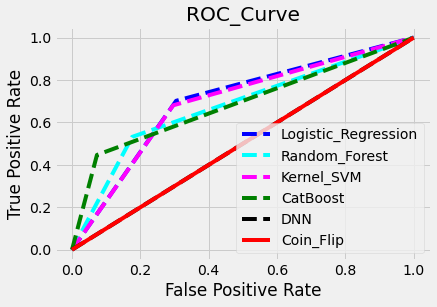

In [83]:
prob = [0 for i in range(len(y_test))]
prob_fpr, prob_tpr, threshold = roc_curve(y_test, prob, pos_label=1)

plt.plot(fpr_LR, tpr_LR, linestyle='--', color='blue', label='Logistic_Regression')
plt.plot(fpr_RFC, tpr_RFC, linestyle='--', color='cyan', label='Random_Forest')
plt.plot(fpr_KSV, tpr_KSV, linestyle='--', color='magenta', label='Kernel_SVM')
plt.plot(fpr_CBC, tpr_CBC, linestyle='--', color='green', label='CatBoost')
plt.plot(fpr_DNN, tpr_DNN, linestyle='--', color='black', label='DNN')
plt.plot(prob_fpr, prob_tpr, linestyle='-', color='red', label="Coin_Flip")
plt.title('ROC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.plot(figsize=(6, 6))
plt.show()

In [84]:
Classification_Report_Summary = (pd.concat([LR_Rep_df, RFC_Rep_df, KSV_Rep_df, CBC_Rep_df, DNN_Rep_df],
                keys=['LR_Rep_df', 'RFC_Rep_df', 'KSV_Rep_df', 'CBC_Rep_df', 'DNN_Rep_df'])).round(decimals=2)

In [85]:
print("------ Classification Report Summary ------")

------ Classification Report Summary ------


In [86]:
Classification_Report_Summary

precision  recall  f1-score  support
LR_Rep_df  0                  0.92    0.70      0.79   233.00
           1                  0.32    0.70      0.44    47.00
           accuracy           0.70    0.70      0.70     0.70
           macro avg          0.62    0.70      0.61   280.00
           weighted avg       0.82    0.70      0.73   280.00
RFC_Rep_df 0                  0.90    0.82      0.86   233.00
           1                  0.38    0.53      0.44    47.00
           accuracy           0.78    0.78      0.78     0.78
           macro avg          0.64    0.68      0.65   280.00
           weighted avg       0.81    0.78      0.79   280.00
KSV_Rep_df 0                  0.92    0.70      0.80   233.00
           1                  0.32    0.68      0.43    47.00
           accuracy           0.70    0.70      0.70     0.70
           macro avg          0.62    0.69      0.61   280.00
           weighted avg       0.82    0.70      0.74   280.00
CBC_Rep_df 0                  0.89    0.93      0.91   233.00
           1                  0.55    0.45      0.49    47.00
           accuracy           0.85    0.85      0.85     0.85
           macro avg          0.72    0.69      0.70   280.00
           weighted avg       0.84    0.85      0.84   280.00
DNN_Rep_df 0                  0.83    1.00      0.91   233.00
           1                  0.00    0.00      0.00    47.00
           accuracy           0.83    0.83      0.83     0.83
           macro avg          0.42    0.50      0.45   280.00
           weighted avg       0.69    0.83      0.76   280.00

### Iteration # 1

Description:
    1. Outliers removed by Z-Score > +/-3
    2. Downsampling of data using Random Under Sampler
    3. ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours', 'MonthlyIncome'] are dropped.

Output:

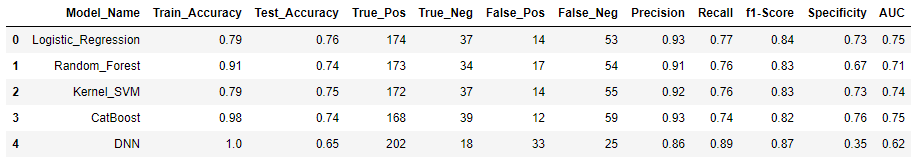
    
Conclusions:
    1. Idea is to have false negative as low as possible, going by this metric DNN model behaves better.
    2. However, train / test accuracy for the DNN model is large and may not be realistic.
    3. SVM appears to be better overall.
    4. Run it with Oversampling.

### Iteration # 2

Description:
    1. Outliers removed by Z-Score > +/- 3.
    2. Upsampling of data using Random Over Sampler.
    3. ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours', 'MonthlyIncome'] are dropped.

Output:

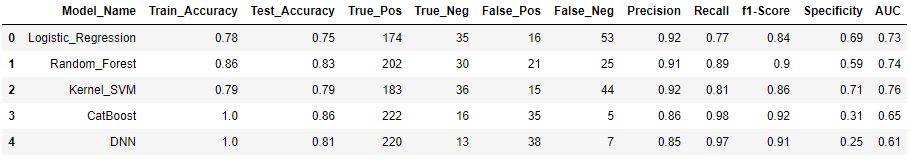

Conclusions:
    1. With upsampling, Random Forest gives good balance between train and test accuracy, Precision & Recall.

### Iteration # 3

Description:
    1. Outliers removed by Z-Score > +/- 3.
    2. Upsampling of data using Random Over Sampler.
    3. Top features from Decsion Tree (refer EDA) alone is considered.
        ['JobLevel', 'OverTime', 'TotalWorkingYears', 'JobRole', 'YearsWithCurrManager', 'Age', 'DistanceFromHome',
        'WorkLifeBalance', 'MaritalStatus', 'YearsSinceLastPromotion', 'Gender', 'TrainingTimesLastYear',
        'RelationshipSatisfaction', 'EnvironmentSatisfaction', 'MonthlyIncome', 'PercentSalaryHike',
        'StockOptionLevel', 'YearsAtCompany', 'Attrition']

Output:

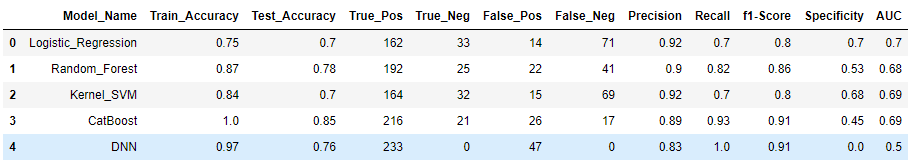

Conclusions:
    1. With feature engineering and upsampling, CatBoost seems to be better.
        - However, train accuracy is 1 and test accuracy is 0.85, likely case of over fitting.
        - Recall and Precision are quite good.

In [87]:
# !jupyter nbconvert --output-dir='C:\DSML_Case_Studies\01_Classification\00_Final_Reports' MLM_CLF_Dataset_IBM_Attrition.ipynb --to html --no-input

C:\ProgramData\Anaconda3\lib\site-packages\traitlets\traitlets.py:2196: FutureWarning: Supporting extra quotes around Unicode is deprecated in traitlets 5.0. Use 'C:\\DSML_Case_Studies\\01_Classification\\00_Final_Reports' instead of "'C:\\DSML_Case_Studies\\01_Classification\\00_Final_Reports'" – or use CUnicode.
  warn(
[NbConvertApp] Converting notebook MLM_CLF_Dataset_IBM_Attrition.ipynb to html
[NbConvertApp] Writing 744309 bytes to C:\DSML_Case_Studies\01_Classification\00_Final_Reports\MLM_CLF_Dataset_IBM_Attrition.html
